## Predict the drug activity against ME/CFS

### TODO
Tune the max_hops, decompositions, and n_comps to show better explanation


### Disease

**Myalgic encephalomyelitis / Fatigue Syndrome, chronic (ME/CFS)**, A syndrome characterized by persistent or recurrent fatigue, diffuse musculoskeletal pain, sleep disturbances, and subjective cognitive impairment of 6 months duration or longer. Symptoms are not caused by ongoing exertion; are not relieved by rest; and result in a substantial reduction of previous levels of occupational, educational, social, or personal activities. Minor alterations of immune, neuroendocrine, and autonomic function may be associated with this syndrome. There is also considerable overlap between this condition and FIBROMYALGIA. (From Semin Neurol 1998;18(2):237-42; Ann Intern Med 1994 Dec 15;121(12): 953-9)

- [MESH: D015673](https://meshb.nlm.nih.gov/record/ui?ui=D015673)
- [DOID: 8544](https://disease-ontology.org/do)

**Long covid**, Post acute stage of COVID-19 virus infection. Persistent symptoms may include FATIGUE; DYSPNEA; and MEMORY LOSS.
*Does not exist in original DRKG*

- [MESH: D000094024](https://www.ncbi.nlm.nih.gov/mesh/?term=long+covid)
- [DOID: 0080848](https://disease-ontology.org/do)

### Drug candidates
Potential drug candidates are listed in **deduplicated_drugs.txt**

In [1]:
import pandas as pd
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Get DRKG

In [2]:
# %%bash
# export DATA_DIR="../models/drkg/data"
# export MODEL_DIR="../models/drkg/models"
# mkdir -p ${DATA_DIR} ${MODEL_DIR}
# wget https://s3.us-west-2.amazonaws.com/dgl-data/dataset/DRKG/drkg.tar.gz -O ${DATA_DIR}/drkg.tar.gz
# tar -xvzf ${DATA_DIR}/drkg.tar.gz -C ${DATA_DIR}

## Disease list

In [3]:
disease_list = [
    'Disease::MESH:D015673',
    'Disease::DOID:8544'
]

## Drug candidate list

In [4]:
candidate_file = 'deduplicated_drugs.txt'
drug_cands = pd.read_csv(candidate_file, sep='\t')
drug_cands

,DrugBankID,DrugName,Category
0,DB00001,Lepirudin,NaN
1,DB00005,Etanercept,NaN
2,DB00006,Bivalirudin,NaN
3,DB00009,Alteplase,NaN
4,DB00013,Urokinase,NaN
...,...,...,...
808,DB17289,L-arginine +/- L-citrulline,Vasodilating
809,DB17508,Hafnium oxide,NaN
810,DB17614,Ergothioneine,Mushroom Derivatives
811,DB17735,Ajoene,NaN


## Treatment relation

In [5]:
treatments = [
    'DRUGBANK::treats::Compound:Disease', 
    'Hetionet::CtD::Compound:Disease',
    'GNBR::T::Compound:Disease'
]

## Load embeddings of disease and drugs

In [6]:
data_dir = '../models/drkg/data'
entity_idmap_file = f'{data_dir}/embed/entities.tsv'
relation_idmap_file = f'{data_dir}/embed/relations.tsv'
entity_emb = np.load(f'{data_dir}/embed/DRKG_TransE_l2_entity.npy')
rel_emb = np.load(f'{data_dir}/embed/DRKG_TransE_l2_relation.npy')


In [7]:
# Get drugname/disease name to entity ID mappings
entity_map = {}
entity_id_map = {}
relation_map = {}
with open(entity_idmap_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['name','id'])
    for row_val in reader:
        entity_map[row_val['name']] = int(row_val['id'])
        entity_id_map[int(row_val['id'])] = row_val['name']
        
with open(relation_idmap_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['name','id'])
    for row_val in reader:
        relation_map[row_val['name']] = int(row_val['id'])
        
# handle the ID mapping
drug_ids = []
disease_ids = []
for _, drug in drug_cands.iterrows():
    drug_name=f'Compound::{drug.DrugBankID}'
    if drug_name in entity_map:
        drug_ids.append(entity_map[drug_name])
    
for disease in disease_list:
    if disease in entity_map:
        disease_ids.append(entity_map[disease])

treatment_rid = [relation_map[treat]  for treat in treatments]

print(f'Total available disease: {len(disease_ids)}')
print(f'Total available drugs: {len(drug_ids)}')
print(f'Total available relations: {len(treatment_rid)}')

Total available disease: 1
Total available drugs: 727
Total available relations: 3


In [8]:
# Load embeddings
drug_ids = torch.tensor(drug_ids).long()
disease_ids = torch.tensor(disease_ids).long()
treatment_rid = torch.tensor(treatment_rid)

drug_emb = torch.tensor(entity_emb[drug_ids])
treatment_embs = [torch.tensor(rel_emb[rid]) for rid in treatment_rid]

print(drug_emb.size())

torch.Size([727, 400])


## Predict edge score
Here, we use L2 loss of pretrained transE model

In [9]:
import torch.nn.functional as fn

gamma=12.0
def transE_l2(head, rel, tail):
    score = head + rel - tail
    return gamma - torch.norm(score, p=2, dim=-1)

scores_per_disease = []
dids = []
for rid in range(len(treatment_embs)):
    treatment_emb=treatment_embs[rid]
    for disease_id in disease_ids:
        disease_emb = entity_emb[disease_id]
        score = fn.logsigmoid(transE_l2(drug_emb, treatment_emb, disease_emb))
        scores_per_disease.append(score)
        dids.append(drug_ids)
scores = torch.cat(scores_per_disease)
dids = torch.cat(dids)

# sort scores in decending order
idx = torch.flip(torch.argsort(scores), dims=[0])
scores = scores[idx].numpy()
dids = dids[idx].numpy()


In [10]:
results = []
for rid in range(len(treatment_embs)):
    treatment_emb=treatment_embs[rid]
    for disease_id in disease_ids:
        disease_emb = entity_emb[disease_id]
        score = fn.logsigmoid(transE_l2(drug_emb, treatment_emb, disease_emb))
        for i in range(len(score)):
            results.append([
                entity_id_map[int(drug_ids[i])].split('::')[-1], 
                float(score[i]), 
                treatments[rid], 
                entity_id_map[int(disease_id)]
            ])
results = pd.DataFrame(results, columns=['DrugBankID', 'Score', 'Treatment', 'Disease_id'])
results

,DrugBankID,Score,Treatment,Disease_id
0,DB00001,-1.555724,DRUGBANK::treats::Compound:Disease,Disease::MESH:D015673
1,DB00005,-0.867009,DRUGBANK::treats::Compound:Disease,Disease::MESH:D015673
2,DB00006,-1.428719,DRUGBANK::treats::Compound:Disease,Disease::MESH:D015673
3,DB00009,-1.602928,DRUGBANK::treats::Compound:Disease,Disease::MESH:D015673
4,DB00013,-1.553212,DRUGBANK::treats::Compound:Disease,Disease::MESH:D015673
...,...,...,...,...
2176,DB15091,-2.734260,GNBR::T::Compound:Disease,Disease::MESH:D015673
2177,DB15536,-1.890350,GNBR::T::Compound:Disease,Disease::MESH:D015673
2178,DB15566,-3.139803,GNBR::T::Compound:Disease,Disease::MESH:D015673
2179,DB15584,-1.230093,GNBR::T::Compound:Disease,Disease::MESH:D015673


In [11]:
# Merge back to results
results = results.merge(drug_cands, on='DrugBankID', how='right').sort_values(by='Score', ascending=False)
results.to_csv('./results.tsv', index=False, sep='\t')
results

,DrugBankID,Score,Treatment,Disease_id,DrugName,Category
689,DB01065,-0.163022,GNBR::T::Compound:Disease,Disease::MESH:D015673,Melatonin,NaN
296,DB00472,-0.181832,GNBR::T::Compound:Disease,Disease::MESH:D015673,Fluoxetine,NaN
578,DB00898,-0.228575,GNBR::T::Compound:Disease,Disease::MESH:D015673,Ethanol,NaN
500,DB00787,-0.238304,GNBR::T::Compound:Disease,Disease::MESH:D015673,Acyclovir,Antibacterials/Antivirals
362,DB00575,-0.252201,GNBR::T::Compound:Disease,Disease::MESH:D015673,Clonidine,NaN
...,...,...,...,...,...,...
2262,DB17289,NaN,NaN,NaN,L-arginine +/- L-citrulline,Vasodilating
2263,DB17508,NaN,NaN,NaN,Hafnium oxide,NaN
2264,DB17614,NaN,NaN,NaN,Ergothioneine,Mushroom Derivatives
2265,DB17735,NaN,NaN,NaN,Ajoene,NaN


## Analysis of the prediction results

In [12]:
# Distribution on treatment
results.groupby('Treatment').describe()

Score                                \
                                    count      mean       std       min   
Treatment                                                                 
DRUGBANK::treats::Compound:Disease  727.0 -1.746991  0.969907 -4.788305   
GNBR::T::Compound:Disease           727.0 -1.474840  0.885838 -4.197554   
Hetionet::CtD::Compound:Disease     727.0 -5.103993  1.229903 -8.269826   

                                                                            
                                         25%       50%       75%       max  
Treatment                                                                   
DRUGBANK::treats::Compound:Disease -2.252396 -1.491235 -0.993599 -0.292414  
GNBR::T::Compound:Disease          -1.918991 -1.285581 -0.743326 -0.163022  
Hetionet::CtD::Compound:Disease    -6.146894 -4.865768 -4.110449 -2.465678

<Axes: xlabel='Score', ylabel='Count'>

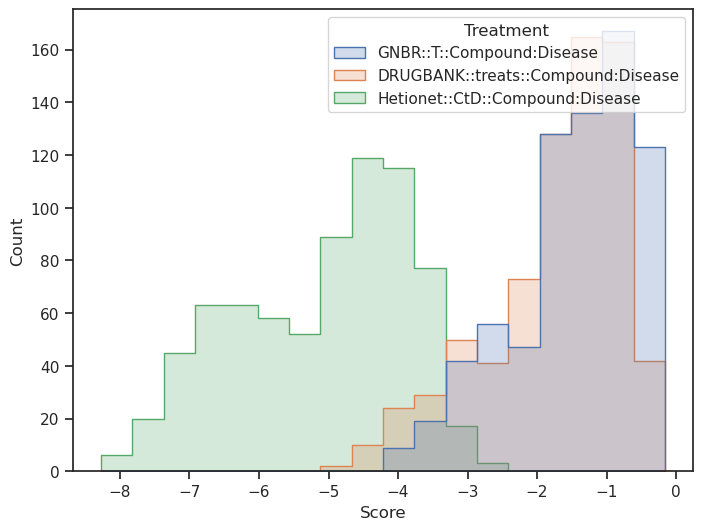

In [13]:
sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x='Score', hue='Treatment', data=results, element='step', ax=ax)

## Explanation of the prediction results

To explain the prediction results, first, we list the path from compound to disease with 0 or 1 hop in between, which directly reflects the potential mechanism of treatment

In [14]:
# load relation glossary map

relations_file = f'{data_dir}/relation_glossary.tsv'

# read relations file
relations = pd.read_csv(relations_file, sep='\t')
relations

,Relation-name,Data-source,Connected entity-types,Interaction-type,Description,Reference for the description
0,DGIDB::ACTIVATOR::Gene:Compound,DGIDB,Compound:Gene,activation,An activator interaction is when a drug activa...,http://www.dgidb.org/getting_started
1,DGIDB::AGONIST::Gene:Compound,DGIDB,Compound:Gene,agonism,An agonist interaction occurs when a drug bind...,http://www.dgidb.org/getting_started
2,DGIDB::ALLOSTERIC MODULATOR::Gene:Compound,DGIDB,Compound:Gene,allosteric modulation,An allosteric modulator interaction occurs whe...,http://www.dgidb.org/getting_started
3,DGIDB::ANTAGONIST::Gene:Compound,DGIDB,Compound:Gene,antagonism,An antagonist interaction occurs when a drug b...,http://www.dgidb.org/getting_started
4,DGIDB::ANTIBODY::Gene:Compound,DGIDB,Compound:Gene,antibody,An antibody interaction occurs when an antibod...,http://www.dgidb.org/getting_started
...,...,...,...,...,...,...
102,bioarx::Covid2_acc_host_gene::Disease:Gene,BIBLIOGRAPHY,Disease:Gene,interaction,"Interactions between 27 viral proteins, and ...",NaN
103,bioarx::DrugHumGen::Compound:Gene,BIBLIOGRAPHY,Compound:Gene,interaction,NaN,NaN
104,bioarx::DrugVirGen::Compound:Gene,BIBLIOGRAPHY,Compound:Gene,interaction,NaN,NaN
105,bioarx::HumGenHumGen::Gene:Gene,BIBLIOGRAPHY,Gene:Gene,interaction,Protein-protein interaction,NaN


In [15]:
# load adj map
adj_file = f'{data_dir}/drkg.tsv'

adjs = {}
with open(adj_file) as fr:
    for l in fr:
        h, r, t = l.rstrip().split('\t')
        if h not in adjs:
            adjs[h] = {}
        if t not in adjs[h]:
            adjs[h][t] = []
        adjs[h][t].append(r)
len(adjs)

57058

In [16]:
# Use BFS to search connections

def bfs_search(src, tgt, hop, seen=None):
    global adjs
    res = []
    # Do not repeat
    if src == tgt:
        return res
    if src not in adjs:
        return res
    if not seen:
        seen = {src}
    # direct connection
    if not hop:
        if tgt not in adjs[src]:
            return []
        for r in adjs[src][tgt]:
            res.append([src, r, tgt])
        return res
    # indirect path
    for mid in adjs[src]:
        if mid in seen:
            continue
        seen.add(mid)
        mid2end = bfs_search(mid, tgt, hop-1, seen)
        if not mid2end:
            continue
        for r in adjs[src][mid]:
            for path in mid2end:
                res.append([src, r, mid] + path[1:])
    return res

# One example output
bfs_search('Gene::2157', 'Gene::5264', 1)
        

[['Gene::2157',
  'STRING::REACTION::Gene:Gene',
  'Gene::351',
  'bioarx::HumGenHumGen::Gene:Gene',
  'Gene::5264'],
 ['Gene::2157',
  'STRING::REACTION::Gene:Gene',
  'Gene::351',
  'Hetionet::GiG::Gene:Gene',
  'Gene::5264']]

In [17]:
# Show paths
def show_path(src, tgt, max_hops, relations):
    res = []
    columns = ['Source']
    for i in range(max_hops+1):
        res += [x + [None]*(max_hops-i)*2 for x in bfs_search(src, tgt, i)]
        columns += [f'relation_{i}', f'hop_{i}']
    df = pd.DataFrame(res, columns=columns)
    # add label
    for i in range(max_hops+1):
        df = df.merge(relations, left_on=f'relation_{i}', right_on='Relation-name', suffixes=('', f'_{i}'), how='left')
    # format df
    df = df.rename(columns={x:f'{x}_0' for x in relations.columns})
    df = df.drop(columns=[f'Relation-name_{i}' for i in range(max_hops+1)])
    return df

show_path('Compound::DB01065', 'Disease::MESH:D015673', 1, relations)

,Source,relation_0,hop_0,relation_1,hop_1,Data-source_0,Connected entity-types_0,Interaction-type_0,Description_0,Reference for the description_0,Data-source_1,Connected entity-types_1,Interaction-type_1,Description_1,Reference for the description_1
0,Compound::DB01065,GNBR::T::Compound:Disease,Disease::MESH:D015673,None,None,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Compound::DB01065,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01149,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
2,Compound::DB01065,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01171,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
3,Compound::DB01065,GNBR::E::Compound:Gene,Gene::1392,GNBR::J::Gene:Disease,Disease::MESH:D015673,GNBR,Compound:Gene,affects expression/production (neutral),NaN,NaN,GNBR,Disease:Gene,role in pathogenesis,NaN,NaN
4,Compound::DB01065,GNBR::E::Compound:Gene,Gene::3479,GNBR::J::Gene:Disease,Disease::MESH:D015673,GNBR,Compound:Gene,affects expression/production (neutral),NaN,NaN,GNBR,Disease:Gene,role in pathogenesis,NaN,NaN
5,Compound::DB01065,GNBR::K::Compound:Gene,Gene::3479,GNBR::J::Gene:Disease,Disease::MESH:D015673,GNBR,Compound:Gene,"metabolism, pharmacokinetics",NaN,NaN,GNBR,Disease:Gene,role in pathogenesis,NaN,NaN
6,Compound::DB01065,GNBR::K::Compound:Gene,Gene::5443,GNBR::J::Gene:Disease,Disease::MESH:D015673,GNBR,Compound:Gene,"metabolism, pharmacokinetics",NaN,NaN,GNBR,Disease:Gene,role in pathogenesis,NaN,NaN


Examples to show paths of top5 genes

In [18]:
tops = 5
max_hops = 1
res = []
for i, x in results.iterrows():
    if i == tops:
        break
    res.append(show_path(f'Compound::{x.DrugBankID}', x.Disease_id, max_hops, relations))
res[1]

,Source,relation_0,hop_0,relation_1,hop_1,Data-source_0,Connected entity-types_0,Interaction-type_0,Description_0,Reference for the description_0,Data-source_1,Connected entity-types_1,Interaction-type_1,Description_1,Reference for the description_1
0,Compound::DB00472,GNBR::T::Compound:Disease,Disease::MESH:D015673,None,None,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB00898,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
2,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01065,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
3,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01171,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
4,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB00915,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
5,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB00787,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
6,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB00575,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
7,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01149,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
8,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01576,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
9,Compound::DB00472,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB00741,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN


Extract drugs with similar embedding and show their paths to disease

In [19]:
from sklearn.decomposition import PCA

def extract_similar(embeddings, tgt, n, decomp, ncomps):
    dc = decomp(n_components=ncomps)
    xy = dc.fit_transform(embeddings)
    scores = np.linalg.norm(xy-xy[tgt], ord=2, axis=1)
    ids = np.argsort(scores)[:n+1]
    ids = ids[ids!=tgt]
    return ids

def find_similar(entity_emb, entity_id_map, tgt, prefix='', n=10, decomp=PCA, ncomps=2):
    # Generate entity matrix
    ids = [k for k,v in entity_id_map.items() if v.startswith(prefix)]
    entity_emb = entity_emb[ids]
    # locate id 
    idx = None
    for i in range(len(ids)):
        if entity_id_map[ids[i]] == tgt:
            idx = i
            break
    # locate similar entities
    cands = extract_similar(entity_emb, idx, n, decomp, ncomps)
    res = []
    for cand in cands:
        res.append([cand, entity_id_map[ids[cand]]])
    return res

find_similar(entity_emb, entity_id_map, 'Compound::DB01065', 'Compound', 5, PCA)

[[1038, 'Compound::DB00521'],
 [1793, 'Compound::DB00504'],
 [12394, 'Compound::DB00417'],
 [3201, 'Compound::DB00233'],
 [766, 'Compound::DB04365']]

Visualize the similar drugs

In [20]:
def draw_pca(entity_emb, entity_id_map, tgt, similars, prefix='', decomp=PCA):
    # select entities
    ids = [k for k,v in entity_id_map.items() if v.startswith(prefix)]
    entity_emb = entity_emb[ids]
    # Dimension reduction
    dc = decomp(n_components=2)
    xy = dc.fit_transform(entity_emb)
    # Backgrounds
    plt.scatter(
        [a[0] for a in xy],
        [a[1] for a in xy],
        color = 'lightgrey',
        label = f'Other {prefix}'
    )
    
    # similars
    plt.scatter(
        [xy[s[0]][0] for s in similars], 
        [xy[s[0]][1] for s in similars], 
        color='b', 
        label=f'Similar {prefix}'
    )
    
    # target
    idx = None
    for i, k in enumerate(ids):
        if entity_id_map[k] == tgt:
            idx = i
    plt.scatter(
        [xy[idx][0]], 
        [xy[idx][1]], 
        color='r', 
        label='Target'
    )
    plt.legend()    

Show similar drugs of example: 'DB01065'

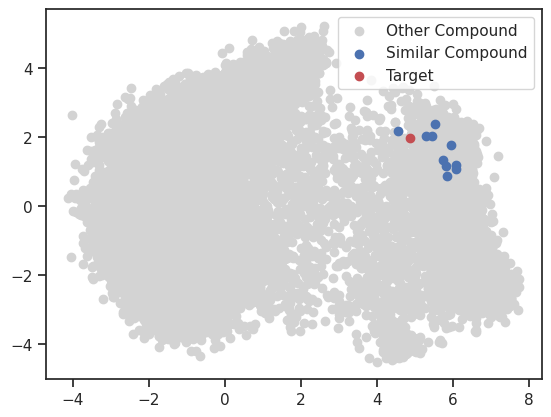

In [21]:
target = 'Compound::DB01065'

similars = find_similar(
    entity_emb, entity_id_map, 
    tgt = target, 
    prefix = 'Compound', 
    n = 10, 
    decomp = PCA,
    ncomps = 50
)

draw_pca(
    entity_emb, entity_id_map, 
    tgt = target, 
    prefix = 'Compound',
    similars = similars, 
    decomp = PCA
)

Show direct connection between similar drugs and disease

In [22]:
def show_path_similar_drugs(
    src, tgt, relations, 
    entity_emb, entity_id_map,
    max_hops=1, n_similars=10, decomp=PCA, ncomps=2):
    # locate similar drugs
    similars = find_similar(
        entity_emb, entity_id_map, 
        tgt = target, 
        prefix = 'Compound', 
        n = n_similars, 
        decomp = decomp,
        ncomps = ncomps
    )
    dfs = []
    for i, s in similars:
        path = show_path(s, tgt, max_hops, relations)
        path = path.rename(columns={'Source':'Similar_drugs'})
        dfs.append(path)
    df = pd.concat(dfs)
    df['Source'] = src
    df = df[[df.columns[-1]] + list(df.columns[:-1])].reset_index().drop(columns=['index'])
    return df

show_path_similar_drugs(
    'Compound::DB01065', 'Disease::MESH:D015673', relations,
    entity_emb, entity_id_map, 
    max_hops=1, 
    n_similars=10, 
    ncomps=50
)
    
    

,Source,Similar_drugs,relation_0,hop_0,relation_1,hop_1,Data-source_0,Connected entity-types_0,Interaction-type_0,Description_0,Reference for the description_0,Data-source_1,Connected entity-types_1,Interaction-type_1,Description_1,Reference for the description_1
0,Compound::DB01065,Compound::DB00898,GNBR::T::Compound:Disease,Disease::MESH:D015673,None,None,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Compound::DB01065,Compound::DB00898,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01065,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
2,Compound::DB01065,Compound::DB00898,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01149,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
3,Compound::DB01065,Compound::DB00898,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB01171,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
4,Compound::DB01065,Compound::DB00898,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB00915,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
5,Compound::DB01065,Compound::DB00898,DRUGBANK::ddi-interactor-in::Compound:Compound,Compound::DB09270,GNBR::T::Compound:Disease,Disease::MESH:D015673,DRUGBANK,Compound:Compound,drug-drug interaction,"In DrugBank, this relation refers to a change ...",https://dev.drugbankplus.com/guides/terms/drug...,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
6,Compound::DB01065,Compound::DB00898,GNBR::B::Compound:Gene,Gene::1392,GNBR::J::Gene:Disease,Disease::MESH:D015673,GNBR,Compound:Gene,"binding, ligand (esp. receptors)",NaN,NaN,GNBR,Disease:Gene,role in pathogenesis,NaN,NaN
7,Compound::DB01065,Compound::DB00898,GNBR::K::Compound:Gene,Gene::1392,GNBR::J::Gene:Disease,Disease::MESH:D015673,GNBR,Compound:Gene,"metabolism, pharmacokinetics",NaN,NaN,GNBR,Disease:Gene,role in pathogenesis,NaN,NaN
8,Compound::DB01065,Compound::DB00898,GNBR::E::Compound:Gene,Gene::1392,GNBR::J::Gene:Disease,Disease::MESH:D015673,GNBR,Compound:Gene,affects expression/production (neutral),NaN,NaN,GNBR,Disease:Gene,role in pathogenesis,NaN,NaN
9,Compound::DB01065,Compound::DB00898,GNBR::E::Compound:Gene,Gene::1401,GNBR::J::Gene:Disease,Disease::MESH:D015673,GNBR,Compound:Gene,affects expression/production (neutral),NaN,NaN,GNBR,Disease:Gene,role in pathogenesis,NaN,NaN


Similarly, find similar diseases of target

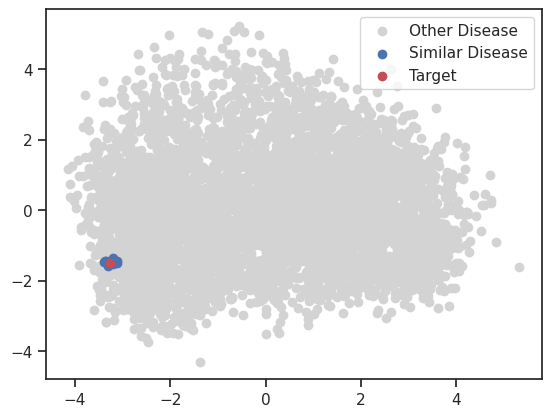

In [23]:
target = 'Disease::MESH:D015673'

similars = find_similar(
    entity_emb, entity_id_map, 
    tgt = target, 
    prefix = 'Disease', 
    n = 10, 
    decomp = PCA,
    ncomps = 2
)

draw_pca(
    entity_emb, entity_id_map, 
    tgt = target, 
    prefix = 'Disease',
    similars = similars, 
    decomp = PCA
)

Show path from drug to similar diseases

In [24]:
def show_path_similar_disease(
    src, tgt, relations, 
    entity_emb, entity_id_map,
    max_hops=1, n_similars=10, decomp=PCA, ncomps=2):
    # locate similar drugs
    similars = find_similar(
        entity_emb, entity_id_map, 
        tgt = target, 
        prefix = 'Disease', 
        n = n_similars, 
        decomp = decomp,
        ncomps = ncomps
    )
    dfs = []
    for i, s in similars:
        path = show_path(src, s, max_hops, relations)
        path['Similar_disease'] = s
        dfs.append(path)
    df = pd.concat(dfs)
    df = df[['Source', df.columns[-1]] + list(df.columns[1:-1])].reset_index().drop(columns=['index'])
    return df

show_path_similar_disease(
    'Compound::DB01065', 'Disease::MESH:D015673', relations,
    entity_emb, entity_id_map, 
    max_hops=0, 
    n_similars=10, 
    ncomps=50
)

,Source,Similar_disease,relation_0,hop_0,Data-source_0,Connected entity-types_0,Interaction-type_0,Description_0,Reference for the description_0
0,Compound::DB01065,Disease::MESH:D007174,GNBR::T::Compound:Disease,Disease::MESH:D007174,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
1,Compound::DB01065,Disease::MESH:D012893,GNBR::T::Compound:Disease,Disease::MESH:D012893,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
2,Compound::DB01065,Disease::MESH:D009771,GNBR::T::Compound:Disease,Disease::MESH:D009771,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
3,Compound::DB01065,Disease::MESH:D001523,GNBR::T::Compound:Disease,Disease::MESH:D001523,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
4,Compound::DB01065,Disease::MESH:D003704,GNBR::T::Compound:Disease,Disease::MESH:D003704,GNBR,Compound:Disease,treatment/therapy (including investigatory),NaN,NaN
